Copyright 2024 Zhixuan Hu

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, sys, json, time, random, types
import torch
import torch.nn as nn               # 用于继承的模型都在这里
import torch.nn.functional as F     # 常用的激活函数、损失函数等
from torchsummary import summary    # 用于模型总结
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

os.chdir('./')                      # 设定工作根目录
sys.path.append(os.path.join(os.getcwd(), '../../'))
from Scripts.arkDLtools.dltools import select_device, Controller, Marker
from torch.utils.collect_env import get_pretty_env_info
env_info = get_pretty_env_info()    # 获取硬件、操作系统、pytorch版本等env信息
device, device_name = select_device()   # device是对象，device_name是设备名称

Intel(R) Arc(TM) Graphics selected.


### 定义评价指标和验证函数

In [2]:
def metrics(outputs, labels): 
    outputs, labels = outputs.cpu(), labels.cpu().numpy()                            # 定义评价指标（准确率）
    preds = torch.where(outputs > 0.5, torch.tensor(1, dtype=torch.int8), torch.tensor(0, dtype=torch.int8))   # 获取预测类别
    preds = preds.numpy()
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return accuracy, precision, recall, f1  # 计算准确率

# 模型验证
def validate(model, Loss=F.cross_entropy, Metrics=metrics, val_loader=None):
    model.eval()                            # 模型切换到推理模式，否则会自动计算梯度，更新参数
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = 0, 0, 0, 0, 0                          # 初始化损失

    for inputs, labels in val_loader:       # 迭代一批次的验证集数据
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)             # 计算模型输出
        loss = Loss(outputs, labels)        # 计算损失函数
        val_loss += loss.item()             # item方法提取出tensor中的数字
        accuracy, precision, recall, f1 = Metrics(outputs, labels)    # 计算评价指标
        val_accuracy += accuracy
        val_precision += precision
        val_recall += recall
        val_f1 += f1
    val_loss /= len(val_loader)             # 计算平均损失
    val_accuracy /= len(val_loader)           # 计算评价指标平均值
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_f1 /= len(val_loader)
    return val_loss, val_accuracy, val_precision, val_recall, val_f1

### 构建数据读取与生成器

In [3]:
pattern = re.compile(r".*\.csv")
data_path = '../../dataset/'
files = os.listdir(data_path)
files = [file for file in files if pattern.match(file)]
files

['chatgpt_HC3_all.csv',
 'gpt_0125_00.csv',
 'human_00.csv',
 'human_01_01.csv',
 'human_01_02.csv',
 'human_02.csv',
 'human_cook_01.csv',
 'human_cook_02.csv',
 'human_HC3_all.csv',
 'human_modern_01.csv',
 'human_modern_02.csv',
 'human_travel_01.csv',
 'human_travel_02.csv',
 'human_travel_03.csv',
 'questions_00.csv',
 'questions_01_01.csv',
 'questions_01_02.csv',
 'questions_02.csv',
 'questions_cook_01.csv',
 'questions_cook_02.csv',
 'questions_HC3_all.csv',
 'questions_modern_01.csv',
 'questions_modern_02.csv',
 'questions_travel_01.csv',
 'questions_travel_02.csv',
 'questions_travel_03.csv',
 'test_gpt_0125.csv',
 'test_human.csv',
 'test_questions.csv']

In [4]:
d_hfiles = [data_path+h for h in ['human_HC3_all.csv', 'test_human.csv']]
d_afiles = [data_path+a for a in ['chatgpt_HC3_all.csv', 'test_gpt_0125.csv']]
model_name = 'sentences_length[mean1,cv1,mean2,cv2]'

d_train_pct = 0.7     # 默认参数：训练集与验证集7:3
d_batch_size = 32     # 默认参数：一个epoch有32个样本
d_num_workers = 0     # 默认参数：同时工作0个进程的取数器
d_embedding_size = 2 * 2 

def default_loader(embedding:str):       
    return torch.tensor(json.loads(embedding))

class DataSet():

    def __init__(self, hfiles: list=None, afiles: list=None, model_name: str=model_name, from_cached: list=None, loader: types.FunctionType=default_loader, transform=None):
        
        if hfiles == None:
            hfiles = d_hfiles
        
        if afiles == None:
            afiles = d_afiles

        if from_cached != None:
            dfs = [pd.read_csv(file) for file in from_cached]
            self.data = pd.concat(dfs).sample(frac=1).reset_index(drop=True)

            if len(dfs) > 1:
                time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
                self.data.to_csv(f'cached_dataset/merged-{time_str}')
                
            self.data[model_name] = self.data[model_name].map(loader)

        else:
            self.model = model_name
            self.loader = loader
            self.transform = transform

            self.hdfs = [pd.read_csv(file) for file in hfiles]
            self.adfs = [pd.read_csv(file) for file in afiles]
            
            self.data = pd.concat((
                pd.concat(self.hdfs).sample(frac=1).reset_index(drop=True).assign(label=0.0), 
                pd.concat(self.adfs).sample(frac=1).reset_index(drop=True).assign(label=1.0)))[[model_name, 'label']].sample(frac=1).reset_index(drop=True)
            
            # 保存这个数据集，便于复现
            time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
            self.data.to_csv(f'cached_dataset/test-{time_str}')
            self.data[model_name] = self.data[model_name].map(loader)

    def __len__(self):                  # 用于度量一批图片的数量
        return len(self.data)

    def __getitem__(self, index):       # 用于取出一批图片
        item = self.data.iloc[index]
        label = torch.tensor([item['label']], dtype=torch.float32)
        return item[model_name], label

    def split(self, train_pct=d_train_pct):   # 用于按train_pct的比例切分训练集和验证集
        train_size = int(len(self) * train_pct)     # 训练集样本数
        valdate_size = len(self) - train_size       # 验证集样本数
        self.train_set, self.validate_set = torch.utils.data.random_split(self, [train_size, valdate_size]) # 切分
        return (self.train_set, self.validate_set)  # 返回切分后的样本

    def loaders(self, batch_size=d_batch_size, num_workers=d_num_workers):  # 多进程返回训练集数据生成器和验证集数据生成器
        self.train_loader = torch.utils.data.DataLoader(self.train_set, 
                                                   batch_size=batch_size, shuffle=True, num_workers=num_workers)    # 训练集打乱
        self.validate_loader = torch.utils.data.DataLoader(self.validate_set, 
                                                     batch_size=batch_size, shuffle=False, num_workers=num_workers) # 验证集不打乱
        return (self.train_loader, self.validate_loader)    


### 测试数据读取与生成器

In [5]:
from torchvision.utils import make_grid         # 用于网格式显示多张图片
full_data = DataSet(from_cached=['cached_dataset/test-2024-06-04-20-46-05'])       # 实例化数据生成器
full_data.split()           # 切分数据集
train_loader, validate_loader = full_data.loaders(num_workers=0)    # 分别生成训练集和验证集的数据生成器
embeddings, labels = next(iter(train_loader))       # 获取训练集第一个批次中的图片及相应标签
print(embeddings.shape)     # 查看该批次图片数目和尺寸
print(labels.shape)     # 查看该批次对应标签的数目

torch.Size([32, 4])
torch.Size([32, 1])


In [81]:
print(len(full_data))
print(len([label for _, label in full_data if label == 1.0]))
print(len([label for _, label in full_data if label == 0.0]))

40173
17695
22478


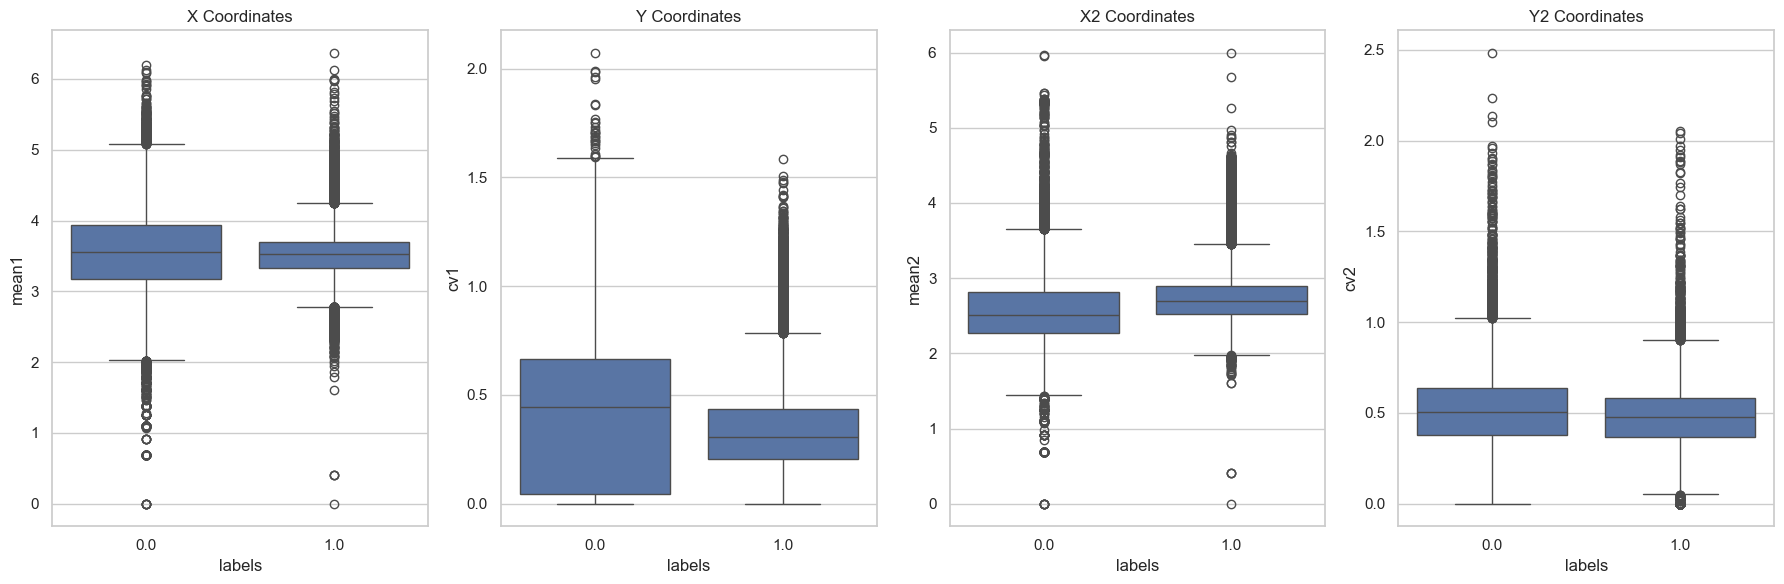

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# 构建数据
data = {
    'mean1': [item[0][0].log().item() for item in full_data],
    'cv1': [item[0][1].item() for item in full_data],
    'mean2': [item[0][2].log().item() for item in full_data],
    'cv2': [item[0][3].item() for item in full_data],
    'labels': [item[1].item() for item in full_data]
}

# 创建DataFrame
df = pd.DataFrame(data)

# 设置绘图风格
sns.set(style="whitegrid")

# 绘制分组箱线图
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# 绘制 x_coords 箱线图
sns.boxplot(ax=axes[0], x='labels', y='mean1', data=df)
axes[0].set_title('X Coordinates')

# 绘制 y_coords 箱线图
sns.boxplot(ax=axes[1], x='labels', y='cv1', data=df)
axes[1].set_title('Y Coordinates')

# 绘制 x2_coords 箱线图
sns.boxplot(ax=axes[2], x='labels', y='mean2', data=df)
axes[2].set_title('X2 Coordinates')

# 绘制 y2_coords 箱线图
sns.boxplot(ax=axes[3], x='labels', y='cv2', data=df)
axes[3].set_title('Y2 Coordinates')


# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

### 模型训练

In [16]:
import statsmodels.api as sm
import pandas as pd

# 构建数据
data = {
    'mean1': [item[0][0].log().item() for item in full_data],
    'cv1': [item[0][1].item() for item in full_data],
    'mean2': [item[0][2].log().item() for item in full_data],
    'cv2': [item[0][3].item() for item in full_data],
    'labels': [item[1].item() for item in full_data]
}

# 创建DataFrame
df = pd.DataFrame(data)
df = df.replace([np.inf, -np.inf], np.nan).dropna()


# 添加常数项（截距项）
df['intercept'] = 1.0

# 定义自变量和因变量
X = df[['intercept', 'mean1', 'cv1', 'mean2', 'cv2']]
y = df['labels']

# 进行逻辑回归
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 输出回归结果
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.636945
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 labels   No. Observations:                40169
Model:                          Logit   Df Residuals:                    40164
Method:                           MLE   Df Model:                            4
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                 0.07158
Time:                        17:48:45   Log-Likelihood:                -25585.
converged:                       True   LL-Null:                       -27558.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9131      0.078    -11.690      0.000      -1.066      -0.760
mean1         -1.0411      0.

Accuracy: 0.6057905349896686
Precision: 0.569914298601714
Recall: 0.4284261090703589
F1: 0.4891441107203923


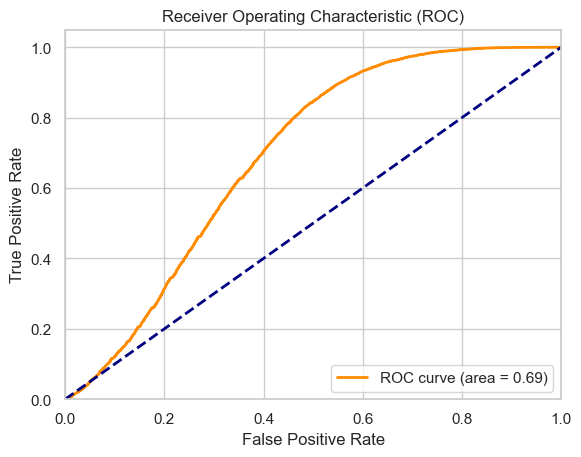

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# 进行预测，预测概率
df['pred_prob'] = result.predict(X)

# 设置阈值0.5进行分类
df['pred_label'] = (df['pred_prob'] >= 0.5).astype(int)

# 计算accuracy, precision, recall, f1
accuracy = accuracy_score(df['labels'], df['pred_label'])
precision = precision_score(df['labels'], df['pred_label'])
recall = recall_score(df['labels'], df['pred_label'])
f1 = f1_score(df['labels'], df['pred_label'])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

# 计算 ROC 曲线和 AUC 值
fpr, tpr, thresholds = roc_curve(df['labels'], df['pred_prob'])
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [18]:
import pickle
# 保存模型参数
with open('sentences_length_202406051750.pkl', 'wb') as f:
    pickle.dump(result.params, f)